<font size=6 color='purple'>**Stellar mass halo mass**</font>

*Notes:* Initialization cells must be run before plotting, since they define functions, colors, and snapshot numbers


In [6]:
import h5py
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from utils.paths import SetupPaths
from utils.get_summary_data import compile_summary
from vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

In [7]:
plt.show()
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in"})


# Initialization

In [8]:
# defining equivalent redshifts
zs = {"z":np.array([0,1,2,3,4]), 
      "zill":np.array([135,85,68,60,56]), 
      "ztng":np.array([99,50,33,25,22])}

In [9]:
# defining color palette for plotting
palette = {"Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC"}


In [10]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask


In [11]:
def get_smhm(sim, phys, size, z, median=False):
    zloc = np.where( zs['z'] == z)[0]
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]      
        
    pair_path = f"{sim}_{snapshot}_10.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["pairs"][phys]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    grouprads = np.array(pairs["Group Radius"])
    groupmass = np.array(pairs["Group Mass"])
    halomass = np.array(pairs["Sub1 Mass"])
    reals = np.array(pairs['Realization'])
    seps = np.array(pairs["Separation"]) 
    
    # masks            
    pair_prims = get_primmask(pri_stell, size)
    pair_gr = get_groupmask(groupmass, size)
    pair_medreal = reals == -1
    pair_lowsep = (seps > 10) & (seps < 10000)

    pair_rvir = seps < grouprads
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)
    majmin = majors | minors

    pair_mask = pair_prims & pair_lowsep & pair_gr & pair_rvir & majmin
    
    if median:
        pair_mask & pair_medreal

        halos = halomass[pair_mask]
        grs = groupmass[pair_mask]
        stars = pri_stell[pair_mask]
        
    elif ~median: 
        halos = halomass[pair_mask]
        grs = groupmass[pair_mask]
        stars = pri_stell[pair_mask]    
                
    mass_dict = {"Halo":halos, "Group":grs, 
                 "Star":stars}
        
    return mass_dict

def get_smhm_simstell(sim, size, z):
    zloc = np.where( zs['z'] == z)[0]
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]      
        
    pair_path = f"{sim}_{snapshot}_simstars.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    pairs = pair_data["paired"]["hydro"]

    pri_stell = np.array(pairs["Sub1 Stellar Mass"])
    sec_stell = np.array(pairs["Sub2 Stellar Mass"])
    grouprads = np.array(pairs["Group Radius"])
    groupmass = np.array(pairs["Group Mass"])
    halomass = np.array(pairs["Sub1 Mass"])
    reals = np.array(pairs['Realization'])
    seps = np.array(pairs["Separation"]) 
    
    # masks            
    pair_prims = get_primmask(pri_stell, size)
    pair_gr = get_groupmask(groupmass, size)
    pair_medreal = reals == -1
    pair_lowsep = (seps > 10) & (seps < 10000)

    pair_rvir = seps < grouprads
    
    majors = (sec_stell/pri_stell > 1/4)
    minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)
    majmin = majors | minors

    pair_mask = pair_prims & pair_lowsep & pair_gr & pair_rvir & majmin

    halos = halomass[pair_mask]
    grs = groupmass[pair_mask]
    stars = pri_stell[pair_mask]

    mass_dict = {"Halo":halos, "Group":grs, 
                 "Star":stars}
        
    return mass_dict

In [7]:
pair_path = f"Illustris_134_10.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")

In [92]:
pair_data['pairs']['hydro'].keys()

<KeysViewHDF5 ['Group ID', 'Group Mass', 'Group Nsubs', 'Group Radius', 'Realization', 'RelVel', 'Separation', 'Stellar Mass Ratio', 'Sub1 BHMass', 'Sub1 BHMdot', 'Sub1 GasMetallicity', 'Sub1 ID', 'Sub1 Mass', 'Sub1 MassType', 'Sub1 Pos', 'Sub1 SFR', 'Sub1 SFRinRad', 'Sub1 Stellar Mass', 'Sub1 Vel', 'Sub2 BHMass', 'Sub2 BHMdot', 'Sub2 GasMetallicity', 'Sub2 ID', 'Sub2 Mass', 'Sub2 MassType', 'Sub2 Pos', 'Sub2 SFR', 'Sub2 SFRinRad', 'Sub2 Stellar Mass', 'Sub2 Vel', 'TripleFlag']>

# Stellar mass halo mass relationship

## Dwarfs

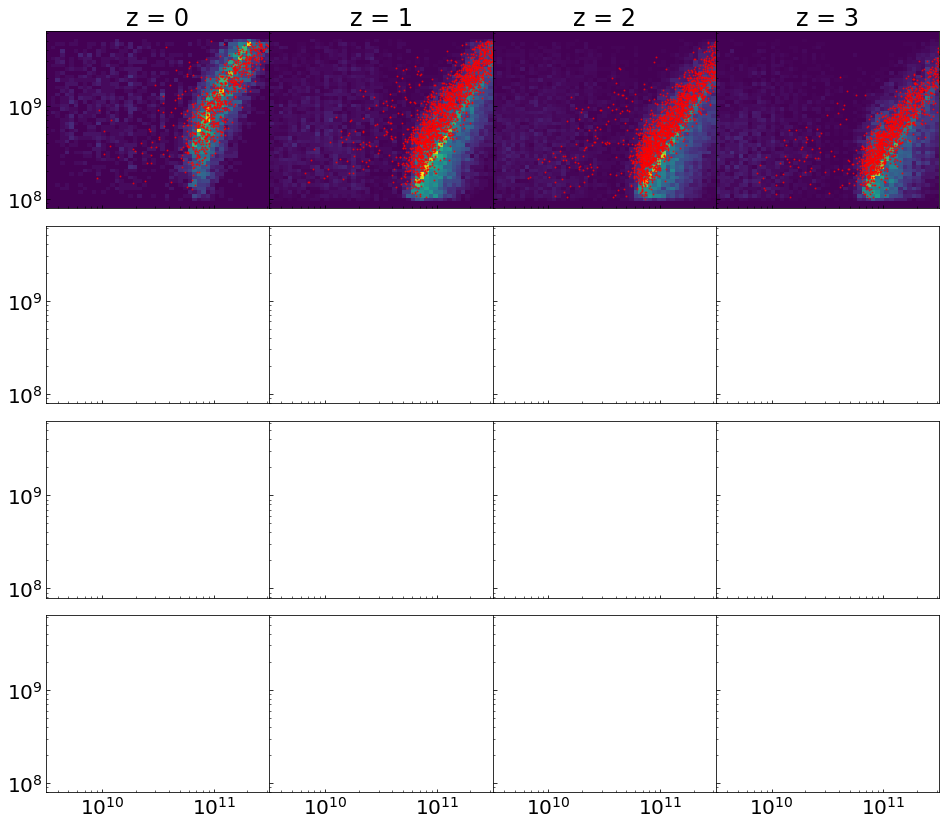

In [35]:
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
binsh = np.logspace(9.5,11.5,50)
binss = np.logspace(7.9,9.8,50)
size = "dwarf"

for i in range(4):

    ax[0][i].set(title=f"z = {i}",xscale='log',yscale='log')

    illd = get_smhm("Illustris","dark", size, i)
#     illh = get_majmin("Illustris","hydro", size, i)
#     tngd = get_majmin("TNG","dark", size, i)
#     tngh = get_majmin("TNG","hydro", size, i)

    illsim = get_smhm_simstell("Illustris", size, i)
#     tngsim = get_majmin_simstell("TNG", size, i, key, **kwargs_dict)

    # Illustris Major pairs
    ax[0][i].hist2d(illd['Halo']*1e10,illd['Star']*1e10,bins=[binsh,binss],label='Dark')
    ax[0][i].scatter(illsim['Halo']*1e10,illsim['Star']*1e10, color='red',alpha=0.7,label='Hydro',s=1)

    # TNG Major pairs
#     ax[1][i].hist(tngd['majors'],weights=np.ones(len(tngd['majors']))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
#     ax[1][i].hist(tngh['majors'],weights=np.ones(len(tngh['majors']))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')

    # Illustris Minor pairs
#     ax[2][i].hist(illd['minors'],weights=np.ones(len(illd['minors']))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
#     ax[2][i].hist(illh['minors'],weights=np.ones(len(illh['minors']))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')

#     # TNG Minor pairs
#     ax[3][i].hist(tngd['minors'],weights=np.ones(len(tngd['minors']))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
#     ax[3][i].hist(tngh['minors'],weights=np.ones(len(tngh['minors']))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')


#     if kwargs_dict['median']:
#         ax[0][i].hist(illsim['majors'],weights=np.ones(len(illsim['majors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
#         ax[1][i].hist(tngsim['majors'],weights=np.ones(len(tngsim['majors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
#         ax[2][i].hist(illsim['minors'],weights=np.ones(len(illsim['minors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
#         ax[3][i].hist(tngsim['minors'],weights=np.ones(len(tngsim['minors']))/weight,histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

# ax[0][3].legend(title="Illustris",fontsize=16)
# ax[1][3].legend(title="TNG",fontsize=16)
# xlims, ylims = ax[0][0].get_xlim(), ax[0][0].get_ylim()
# xwidth, ywidth = np.diff(xlims), np.diff(ylims)


# ax[0][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Major Pairs",va='top')
# ax[2][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Minor Pairs",va='top')

# fig.suptitle("Dwarf pair separations",y=0.95)
# fig.supxlabel(r"Separation (kpc)",y=0.06)
# fig.supylabel("Count [thousands]",x=0.060)

# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

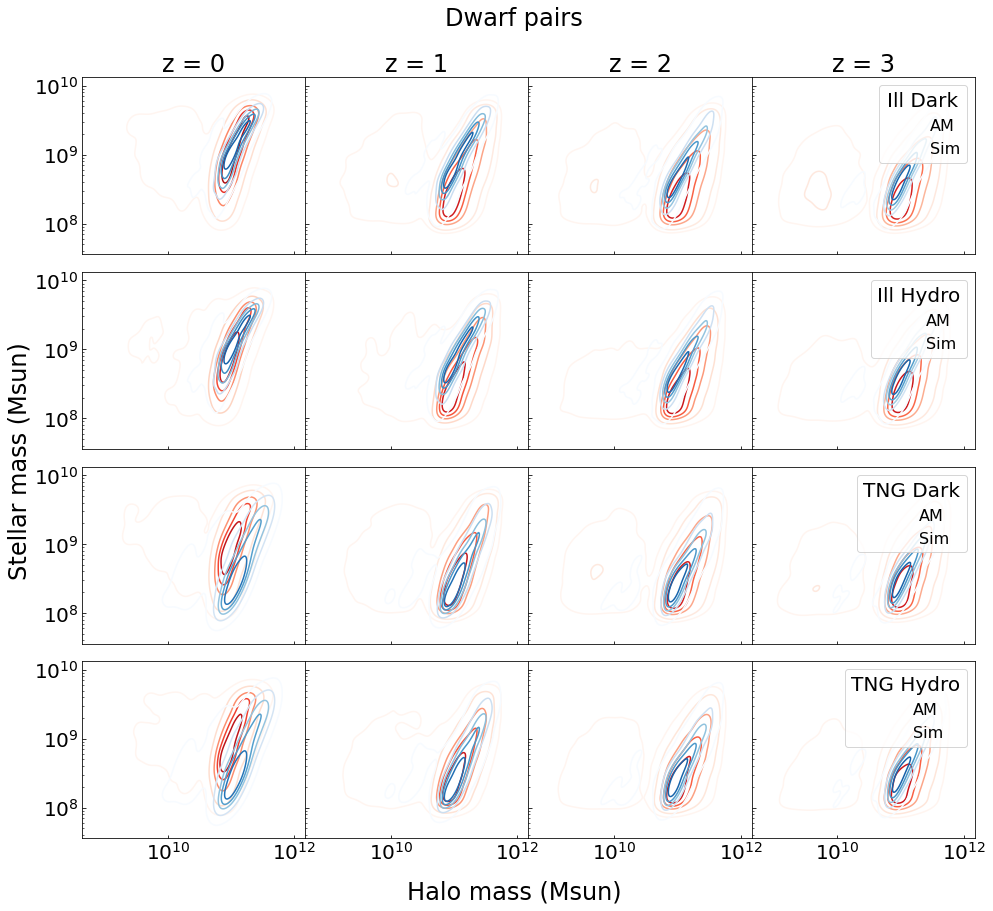

In [34]:
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
size = "dwarf"

for i in range(4):

    ax[0][i].set(title=f"z = {i}",xscale='log',yscale='log')

    illd = get_smhm("Illustris","dark", size, i,median=True)
    illh = get_smhm("Illustris","hydro", size, i,median=True)
    tngd = get_smhm("TNG","dark", size, i,median=True)
    tngh = get_smhm("TNG","hydro", size, i,median=True)

    illsim = get_smhm_simstell("Illustris", size, i)
    tngsim = get_smhm_simstell("TNG", size, i)

    # Illustris Major pairs
    sns.kdeplot(x=illd['Halo']*1e10,y=illd['Star']*1e10,cmap="Reds",levels=6, fill=False,ax=ax[0][i],label="AM")
    sns.kdeplot(x=illsim['Halo']*1e10,y=illsim['Star']*1e10,cmap="Blues",levels=6, fill=False,ax=ax[0][i],label="Sim")

    # Illustris Major pairs
    sns.kdeplot(x=illh['Halo']*1e10,y=illh['Star']*1e10,cmap="Reds",levels=6, fill=False,ax=ax[1][i],label="AM")
    sns.kdeplot(x=illsim['Halo']*1e10,y=illsim['Star']*1e10,cmap="Blues",levels=6, fill=False,ax=ax[1][i],label="Sim")

    
    # TNG Major pairs
    sns.kdeplot(x=tngd['Halo']*1e10,y=tngd['Star']*1e10,cmap="Reds",levels=6, fill=False,ax=ax[2][i],label="AM")
    sns.kdeplot(x=tngsim['Halo']*1e10,y=tngsim['Star']*1e10,cmap="Blues",levels=6, fill=False,ax=ax[2][i],label="Sim")

    sns.kdeplot(x=tngh['Halo']*1e10,y=tngh['Star']*1e10,cmap="Reds",levels=6, fill=False,ax=ax[3][i],label="AM")
    sns.kdeplot(x=tngsim['Halo']*1e10,y=tngsim['Star']*1e10,cmap="Blues",levels=6, fill=False,ax=ax[3][i],label="Sim")

ax[0][3].legend(title="ILL Dark",fontsize=16)
ax[1][3].legend(title="ILL Hydro",fontsize=16)
ax[2][3].legend(title="TNG Dark",fontsize=16)
ax[3][3].legend(title="TNG Hydro",fontsize=16)
# xlims, ylims = ax[0][0].get_xlim(), ax[0][0].get_ylim()
# xwidth, ywidth = np.diff(xlims), np.diff(ylims)


# ax[0][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Major Pairs",va='top')
# ax[2][0].text(xlims[0]+0.05*xwidth,ylims[1]-0.05*ywidth,"Minor Pairs",va='top')

fig.suptitle("Dwarf pairs",y=0.95)
fig.supxlabel(r"Halo mass (Msun)",y=0.06)
fig.supylabel("Stellar mass (Msun)",x=0.060)

# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

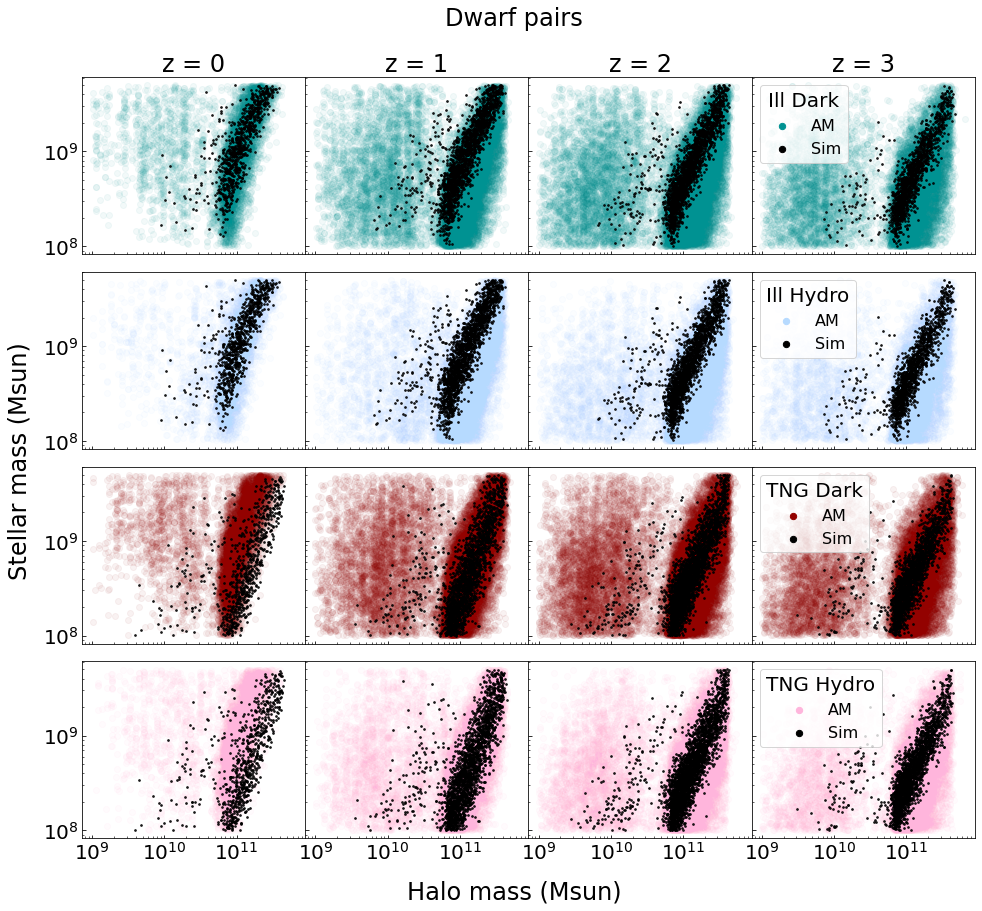

In [77]:
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
size = "dwarf"
median = False



for i in range(4):
    ax[0][i].set(title=f"z = {i}",xscale='log',yscale='log')

    illd = get_smhm("Illustris","dark", size, i,median=median)
    illh = get_smhm("Illustris","hydro", size, i,median=median)
    tngd = get_smhm("TNG","dark", size, i,median=median)
    tngh = get_smhm("TNG","hydro", size, i,median=median)

    illsim = get_smhm_simstell("Illustris", size, i)
    tngsim = get_smhm_simstell("TNG", size, i)

    # Illustris Major pairs
    ax[0][i].scatter(x=illd['Halo']*1e10,y=illd['Star']*1e10,label="AM",color=palette['Illustris dark'],alpha=0.05)
    ax[0][i].scatter(x=illsim['Halo']*1e10,y=illsim['Star']*1e10,label="Sim",color='black',alpha=0.8,s=3)

    # Illustris Major pairs
    ax[1][i].scatter(x=illh['Halo']*1e10,y=illh['Star']*1e10,label="AM",color=palette['Illustris hydro'],alpha=0.05)
    ax[1][i].scatter(x=illsim['Halo']*1e10,y=illsim['Star']*1e10,label="Sim",color='black',alpha=0.8,s=3)

    
    # TNG Major pairs
    ax[2][i].scatter(x=tngd['Halo']*1e10,y=tngd['Star']*1e10,label="AM",color=palette['TNG dark'],alpha=0.05)
    ax[2][i].scatter(x=tngsim['Halo']*1e10,y=tngsim['Star']*1e10,label="Sim",color='black',alpha=0.8,s=3)

    ax[3][i].scatter(x=tngh['Halo']*1e10,y=tngh['Star']*1e10,label="AM",color=palette['TNG hydro'],alpha=0.05)
    ax[3][i].scatter(x=tngsim['Halo']*1e10,y=tngsim['Star']*1e10,label="Sim",color='black',alpha=0.8,s=3)

for i,lab in enumerate(["Ill Dark", "Ill Hydro", "TNG Dark", "TNG Hydro"]):
    leg = ax[i][3].legend(title=lab,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [40]
        
fig.suptitle("Dwarf pairs",y=0.95)
fig.supxlabel(r"Halo mass (Msun)",y=0.06)
fig.supylabel("Stellar mass (Msun)",x=0.060)

# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

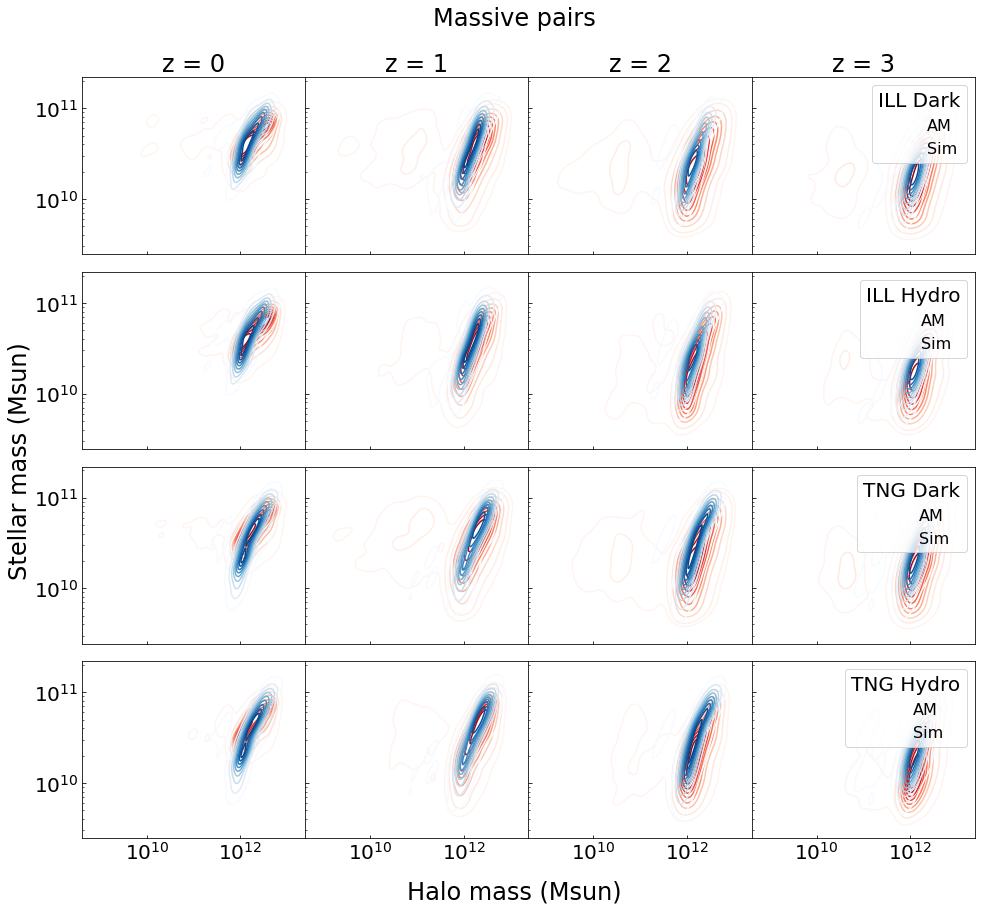

In [38]:
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
size = "massive"



for i in range(4):

    ax[0][i].set(title=f"z = {i}",xscale='log',yscale='log')

    illd = get_smhm("Illustris","dark", size, i,median=True)
    illh = get_smhm("Illustris","hydro", size, i,median=True)
    tngd = get_smhm("TNG","dark", size, i,median=True)
    tngh = get_smhm("TNG","hydro", size, i,median=True)

    illsim = get_smhm_simstell("Illustris", size, i)
    tngsim = get_smhm_simstell("TNG", size, i)

    # Illustris Major pairs
    sns.kdeplot(x=illd['Halo']*1e10,y=illd['Star']*1e10,cmap="Reds",levels=10, fill=False,ax=ax[0][i],label="AM")
    sns.kdeplot(x=illsim['Halo']*1e10,y=illsim['Star']*1e10,cmap="Blues",levels=10, fill=False,ax=ax[0][i],label="Sim")

    # Illustris Major pairs
    sns.kdeplot(x=illh['Halo']*1e10,y=illh['Star']*1e10,cmap="Reds",levels=10, fill=False,ax=ax[1][i],label="AM")
    sns.kdeplot(x=illsim['Halo']*1e10,y=illsim['Star']*1e10,cmap="Blues",levels=10, fill=False,ax=ax[1][i],label="Sim")

    
    # TNG Major pairs
    sns.kdeplot(x=tngd['Halo']*1e10,y=tngd['Star']*1e10,cmap="Reds",levels=10, fill=False,ax=ax[2][i],label="AM")
    sns.kdeplot(x=tngsim['Halo']*1e10,y=tngsim['Star']*1e10,cmap="Blues",levels=10, fill=False,ax=ax[2][i],label="Sim")

    sns.kdeplot(x=tngh['Halo']*1e10,y=tngh['Star']*1e10,cmap="Reds",levels=10, fill=False,ax=ax[3][i],label="AM")
    sns.kdeplot(x=tngsim['Halo']*1e10,y=tngsim['Star']*1e10,cmap="Blues",levels=10, fill=False,ax=ax[3][i],label="Sim")

ax[0][3].legend(title="ILL Dark",fontsize=16)
ax[1][3].legend(title="ILL Hydro",fontsize=16)
ax[2][3].legend(title="TNG Dark",fontsize=16)
ax[3][3].legend(title="TNG Hydro",fontsize=16)

fig.suptitle("Massive pairs",y=0.95)
fig.supxlabel(r"Halo mass (Msun)",y=0.06)
fig.supylabel("Stellar mass (Msun)",x=0.060)

# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

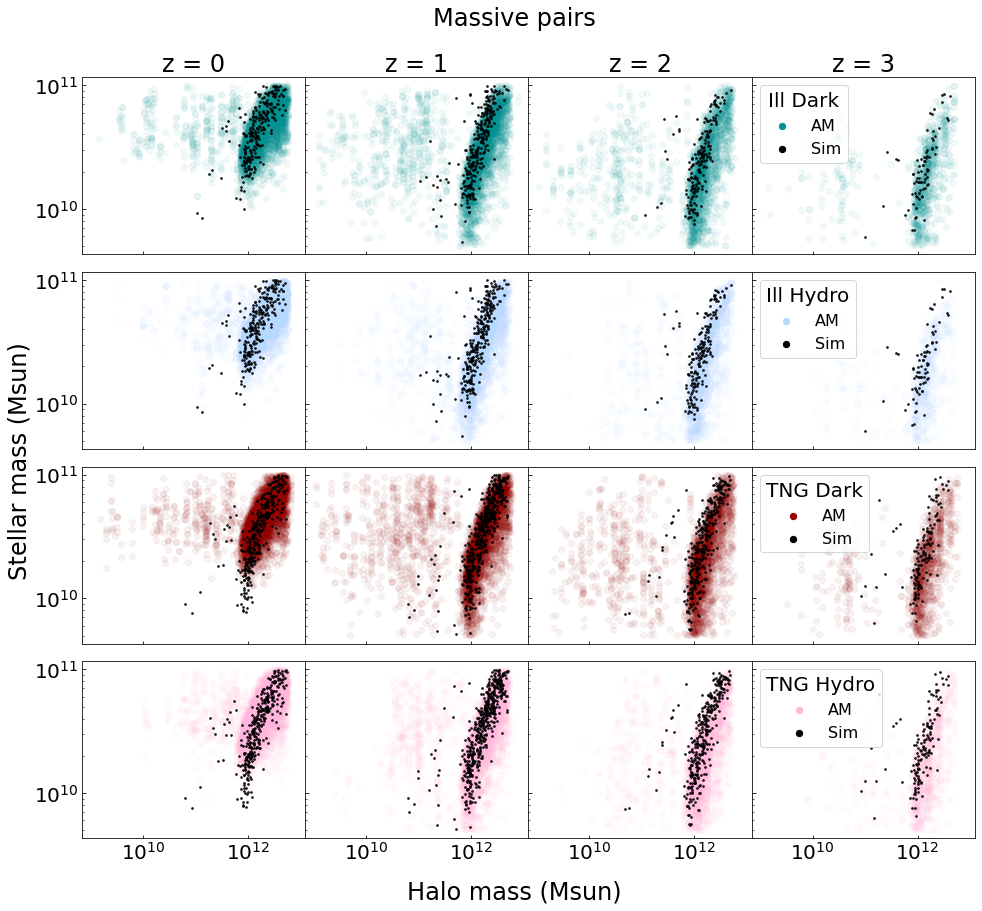

In [76]:
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
size = "massive"
median = False

for i in range(4):
    ax[0][i].set(title=f"z = {i}",xscale='log',yscale='log')

    illd = get_smhm("Illustris","dark", size, i,median=median)
    illh = get_smhm("Illustris","hydro", size, i,median=median)
    tngd = get_smhm("TNG","dark", size, i,median=median)
    tngh = get_smhm("TNG","hydro", size, i,median=median)

    illsim = get_smhm_simstell("Illustris", size, i)
    tngsim = get_smhm_simstell("TNG", size, i)

    # Illustris Major pairs
    ax[0][i].scatter(x=illd['Halo']*1e10,y=illd['Star']*1e10,label="AM",color=palette['Illustris dark'],alpha=0.05)
    ax[0][i].scatter(x=illsim['Halo']*1e10,y=illsim['Star']*1e10,label="Sim",color='black',alpha=0.8,s=3)

    # Illustris Major pairs
    ax[1][i].scatter(x=illh['Halo']*1e10,y=illh['Star']*1e10,label="AM",color=palette['Illustris hydro'],alpha=0.05)
    ax[1][i].scatter(x=illsim['Halo']*1e10,y=illsim['Star']*1e10,label="Sim",color='black',alpha=0.8,s=3)

    
    # TNG Major pairs
    ax[2][i].scatter(x=tngd['Halo']*1e10,y=tngd['Star']*1e10,label="AM",color=palette['TNG dark'],alpha=0.05)
    ax[2][i].scatter(x=tngsim['Halo']*1e10,y=tngsim['Star']*1e10,label="Sim",color='black',alpha=0.8,s=3)

    ax[3][i].scatter(x=tngh['Halo']*1e10,y=tngh['Star']*1e10,label="AM",color=palette['TNG hydro'],alpha=0.05)
    ax[3][i].scatter(x=tngsim['Halo']*1e10,y=tngsim['Star']*1e10,label="Sim",color='black',alpha=0.8,s=3)

for i,lab in enumerate(["Ill Dark", "Ill Hydro", "TNG Dark", "TNG Hydro"]):
    leg = ax[i][3].legend(title=lab,fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [40]
        
fig.suptitle("Massive pairs",y=0.95)
fig.supxlabel(r"Halo mass (Msun)",y=0.06)
fig.supylabel("Stellar mass (Msun)",x=0.060)

# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

# SM/HM ratio vs. HM

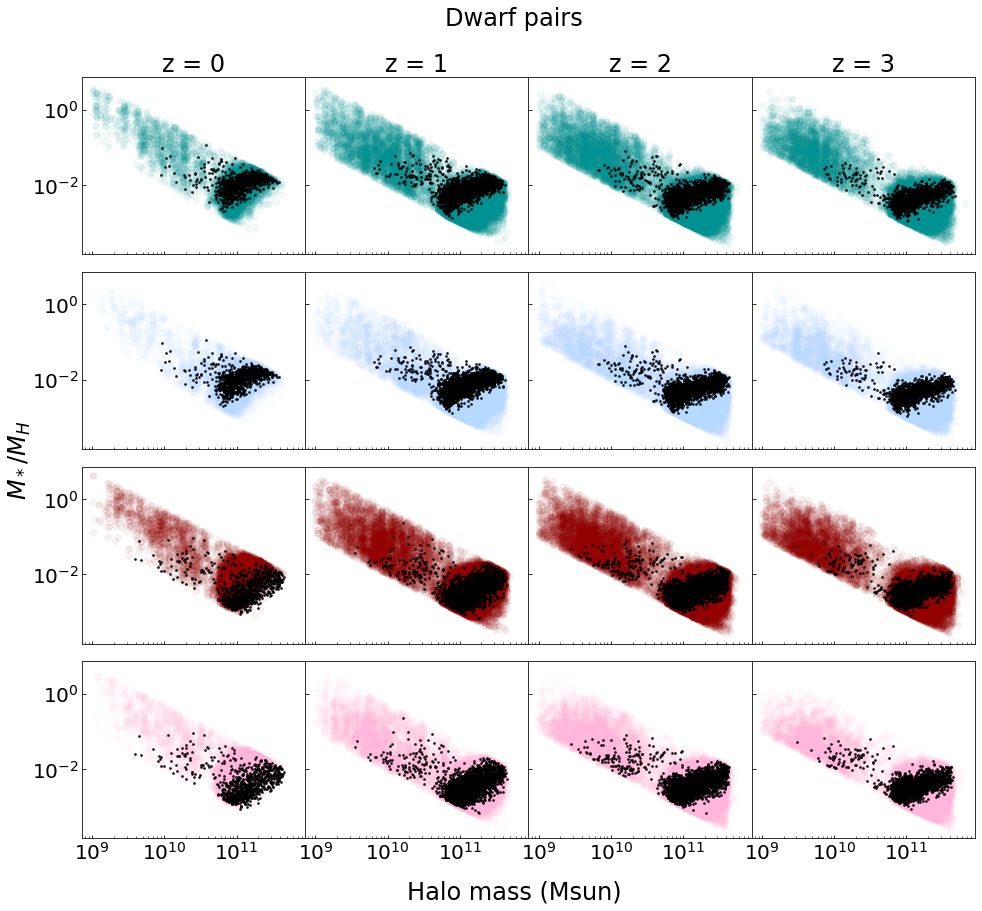

In [88]:
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
size = "dwarf"
median = True

for i in range(4):
    ax[0][i].set(title=f"z = {i}",xscale='log',yscale='log')

    illd = get_smhm("Illustris","dark", size, i,median=median)
    illh = get_smhm("Illustris","hydro", size, i,median=median)
    tngd = get_smhm("TNG","dark", size, i,median=median)
    tngh = get_smhm("TNG","hydro", size, i,median=median)

    illsim = get_smhm_simstell("Illustris", size, i)
    tngsim = get_smhm_simstell("TNG", size, i)

    # Illustris Major pairs
    ax[0][i].scatter(x=illd['Halo']*1e10,y=illd['Star']/illd['Halo'],label="AM",color=palette['Illustris dark'],alpha=0.05)
    ax[0][i].scatter(x=illsim['Halo']*1e10,y=illsim['Star']/illsim['Halo'],label="Sim",color='black',alpha=0.8,s=3)

    # Illustris Major pairs
    ax[1][i].scatter(x=illh['Halo']*1e10,y=illh['Star']/illh['Halo'],label="AM",color=palette['Illustris hydro'],alpha=0.05)
    ax[1][i].scatter(x=illsim['Halo']*1e10,y=illsim['Star']/illsim['Halo'],label="Sim",color='black',alpha=0.8,s=3)

    
    # TNG Major pairs
    ax[2][i].scatter(x=tngd['Halo']*1e10,y=tngd['Star']/tngd['Halo'],label="AM",color=palette['TNG dark'],alpha=0.05)
    ax[2][i].scatter(x=tngsim['Halo']*1e10,y=tngsim['Star']/tngsim['Halo'],label="Sim",color='black',alpha=0.8,s=3)

    ax[3][i].scatter(x=tngh['Halo']*1e10,y=tngh['Star']/tngh['Halo'],label="AM",color=palette['TNG hydro'],alpha=0.05)
    ax[3][i].scatter(x=tngsim['Halo']*1e10,y=tngsim['Star']/tngsim['Halo'],label="Sim",color='black',alpha=0.8,s=3)

# for i,lab in enumerate(["Ill Dark", "Ill Hydro", "TNG Dark", "TNG Hydro"]):
#     leg = ax[i][3].legend(title=lab,fontsize=16)

#     for lh in leg.legendHandles: 
#         lh.set_alpha(1)
#         lh._sizes = [40]
        
fig.suptitle("Dwarf pairs",y=0.95)
fig.supxlabel(r"Halo mass (Msun)",y=0.06)
fig.supylabel(r"$M_*/M_H$",x=0.060)


# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

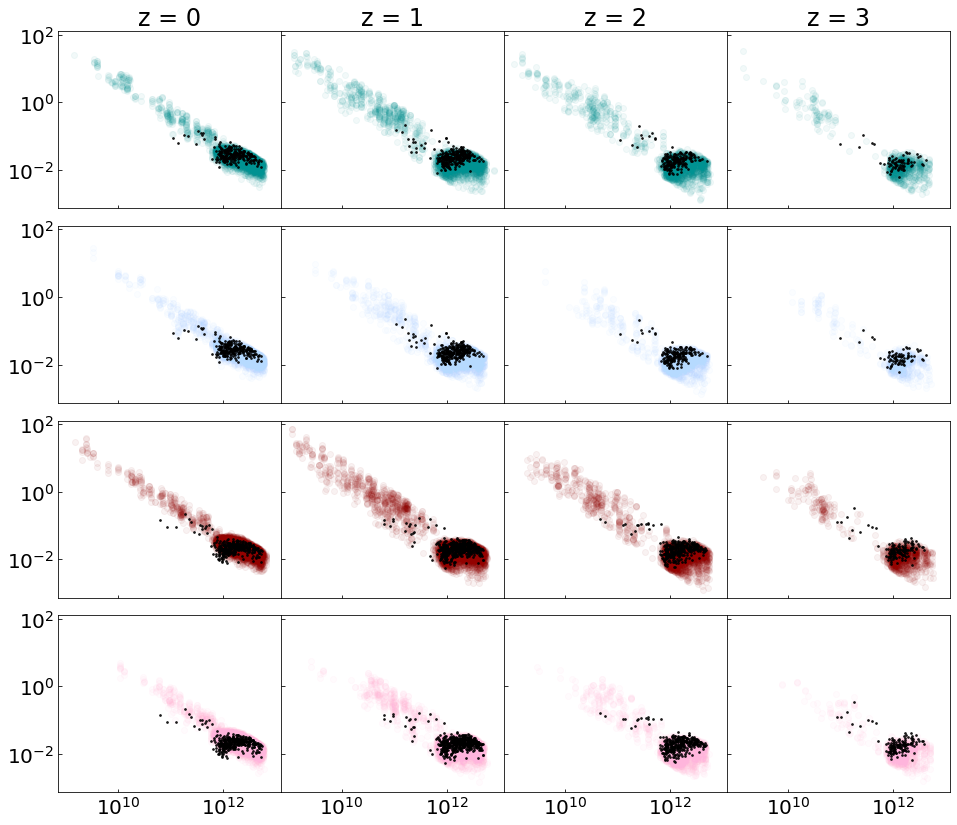

In [83]:
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
size = "massive"
median = False

for i in range(4):
    ax[0][i].set(title=f"z = {i}",xscale='log',yscale='log')

    illd = get_smhm("Illustris","dark", size, i,median=median)
    illh = get_smhm("Illustris","hydro", size, i,median=median)
    tngd = get_smhm("TNG","dark", size, i,median=median)
    tngh = get_smhm("TNG","hydro", size, i,median=median)

    illsim = get_smhm_simstell("Illustris", size, i)
    tngsim = get_smhm_simstell("TNG", size, i)

    # Illustris Major pairs
    ax[0][i].scatter(x=illd['Halo']*1e10,y=illd['Star']/illd['Halo'],label="AM",color=palette['Illustris dark'],alpha=0.05)
    ax[0][i].scatter(x=illsim['Halo']*1e10,y=illsim['Star']/illsim['Halo'],label="Sim",color='black',alpha=0.8,s=3)

    # Illustris Major pairs
    ax[1][i].scatter(x=illh['Halo']*1e10,y=illh['Star']/illh['Halo'],label="AM",color=palette['Illustris hydro'],alpha=0.05)
    ax[1][i].scatter(x=illsim['Halo']*1e10,y=illsim['Star']/illsim['Halo'],label="Sim",color='black',alpha=0.8,s=3)

    
    # TNG Major pairs
    ax[2][i].scatter(x=tngd['Halo']*1e10,y=tngd['Star']/tngd['Halo'],label="AM",color=palette['TNG dark'],alpha=0.05)
    ax[2][i].scatter(x=tngsim['Halo']*1e10,y=tngsim['Star']/tngsim['Halo'],label="Sim",color='black',alpha=0.8,s=3)

    ax[3][i].scatter(x=tngh['Halo']*1e10,y=tngh['Star']/tngh['Halo'],label="AM",color=palette['TNG hydro'],alpha=0.05)
    ax[3][i].scatter(x=tngsim['Halo']*1e10,y=tngsim['Star']/tngsim['Halo'],label="Sim",color='black',alpha=0.8,s=3)

# for i,lab in enumerate(["Ill Dark", "Ill Hydro", "TNG Dark", "TNG Hydro"]):
#     leg = ax[i][3].legend(title=lab,fontsize=16)

#     for lh in leg.legendHandles: 
#         lh.set_alpha(1)
#         lh._sizes = [40]
        
# fig.suptitle("Massive pairs",y=0.95)
fig.supxlabel(r"$M_*/M_H$",y=0.06)
# fig.supylabel("Stellar mass (Msun)",x=0.060)

# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

____
# Debug scratch graveyard etc etc 

In [7]:
size = "dwarf"
median = False
illd = get_smhm("Illustris","dark", size, 0, median=True)
illsim = get_smhm_simstell("Illustris", size, 0)

fig, ax = plt.subplots(1, 1, figsize=(12,8), sharey=True, sharex=True)
# plt.subplots_adjust(wspace=0,hspace=0.1)

ax.set(xscale='log',yscale='log')      

# ax.scatter(x=maxbig[randmask], y=starsbig[randmask], label="AM", color="grey", alpha=0.3, s=3)
ax.scatter(x=maxes, y=medes, label="AM", color="pink", alpha=0.1, s=5)
ax.scatter(x=mases, y=medes, label="AM", color="red", alpha=0.1, s=5)

ax.scatter(x=illd['Halo']*1e10,y=illd['Star']*1e10,label="AM",color=palette['Illustris dark'],alpha=0.05)
ax.scatter(x=illsim['Halo']*1e10,y=illsim['Star']*1e10,label="AM",color='black',alpha=0.05)


plt.show()




NameError: name 'get_smhm' is not defined

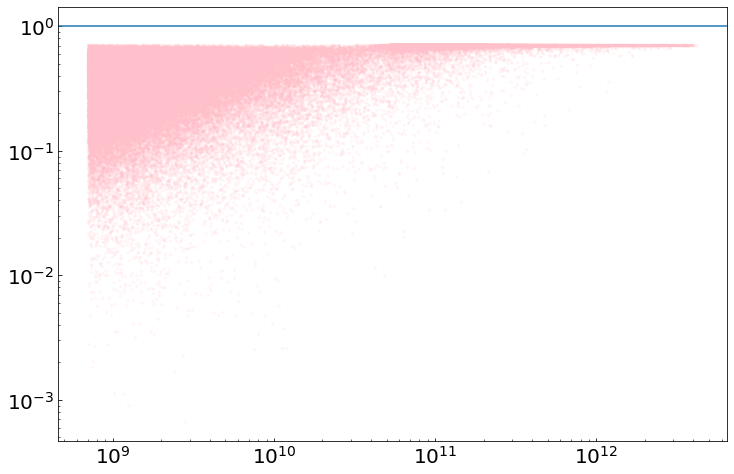

In [19]:
# size = "dwarf"
# median = False
# illd = get_smhm("Illustris","dark", size, 0, median=median)
# illsim = get_smhm_simstell("Illustris", size, 0)

fig, ax = plt.subplots(1, 1, figsize=(12,8), sharey=True, sharex=True)
# plt.subplots_adjust(wspace=0,hspace=0.1)

ax.set(xscale='log',yscale='log')      

# ax.scatter(x=maxbig[randmask], y=starsbig[randmask], label="AM", color="grey", alpha=0.3, s=3)
ax.scatter(x=mases, y=mases/maxes, label="AM", color="pink", alpha=0.1, s=5)
ax.axhline(1)
# ax.scatter(x=mases, y=mases, label="AM", color="red", alpha=0.1, s=5)


plt.show()


In [13]:
am_data = h5py.File(f"../data/am_masses/TNG_dark_99.hdf5", "r")

In [14]:
am_data.keys()

<KeysViewHDF5 ['Current Snap Mass', 'Group ID', 'Max Mass', 'Max Mass Snap', 'Median Stellar Mass', 'Stellar Masses', 'Subhalo ID']>

In [15]:
snap = np.array(am_data['Max Mass Snap'])
snapmask = snap==99
sum(snapmask)

13531

In [16]:
maxes = np.array(am_data['Max Mass'])*1e10
mases = np.array(am_data['Current Snap Mass'])*1e10
medes = np.array(am_data['Median Stellar Mass'])*1e10

In [17]:
maxes = np.array(am_data['Max Mass'])*1e10
mases = np.array(am_data['Current Snap Mass'])*1e10
maskk = np.where(mases > 0.5*maxes)

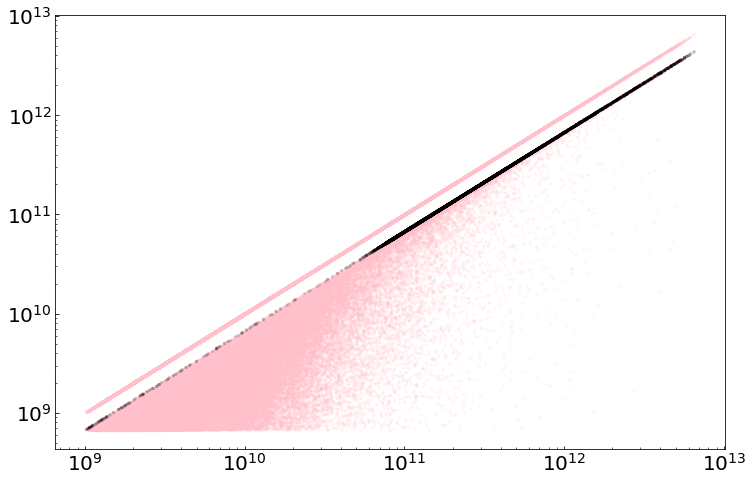

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharey=True, sharex=True)

ax.set(xscale='log',yscale='log')      
ax.scatter(x=maxes, y=mases, label="AM", color="pink", alpha=0.1, s=5)
ax.scatter(x=maxes, y=maxes, label="AM", color="pink", alpha=0.1, s=5)
ax.scatter(x=maxes[snapmask], y=mases[snapmask], label="AM", color="black", alpha=0.1, s=5)


plt.show()


In [19]:
stellars = np.array(am_data['Stellar Masses'])*1e10

In [20]:
stellaretc = []
for i in range(len(maxes)):
    stellaretc.append(np.ones(len(stellars[i]))*maxes[i])


In [21]:
maxbig = np.reshape(stellaretc,len(stellars[0])*len(maxes) )
starsbig = np.reshape(stellars,len(stellars[0])*len(maxes) )

In [22]:
len(maxbig)

135063000

In [23]:
randmask = np.random.randint(0,len(maxbig),10000)

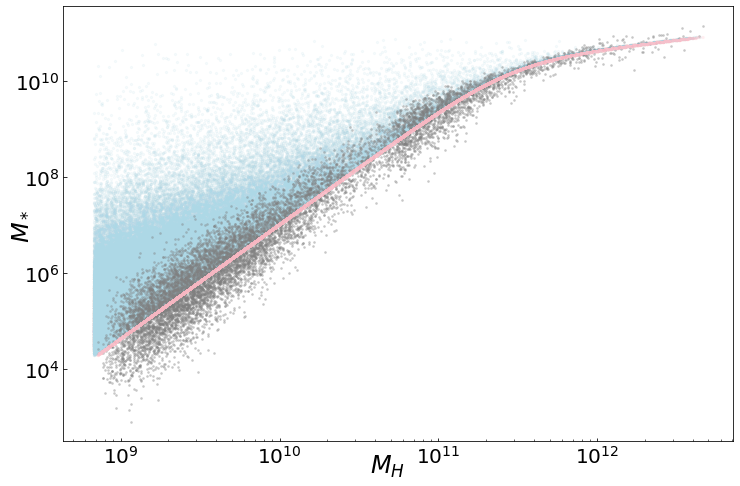

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharey=True, sharex=True)
# plt.subplots_adjust(wspace=0,hspace=0.1)

ax.set(xscale='log',yscale='log')      
ax.scatter(x=mases, y=medes, label="AM", color="lightblue", alpha=0.1, s=5)
ax.scatter(x=maxbig[randmask]*0.704, y=starsbig[randmask], label="AM", color="grey", alpha=0.3, s=3)
ax.scatter(x=maxes*0.704, y=medes, label="AM", color="pink", alpha=0.1, s=5)


# fig.suptitle("Massive pairs",y=0.95)
fig.supxlabel(r"$M_H$",y=0.06)
fig.supylabel(r"$M_*$",x=0.06)


# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

NameError: name 'maxstars' is not defined

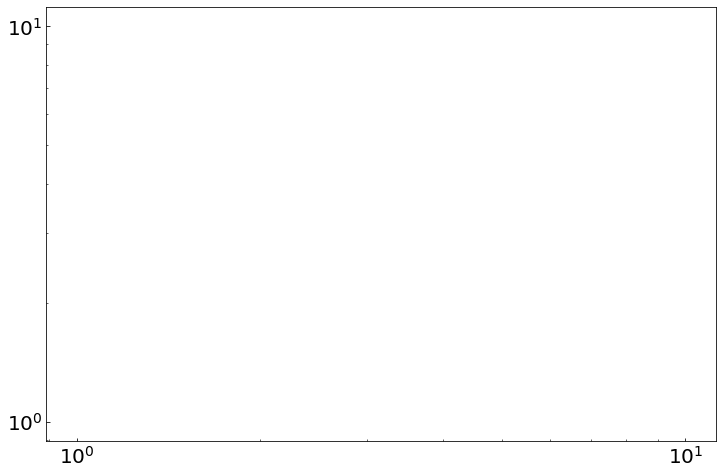

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12,8),sharey=True,sharex=True)
# plt.subplots_adjust(wspace=0,hspace=0.1)

ax.set(xscale='log',yscale='log')      
ax.scatter(x=maxbig[randmask],y=maxstars[randmask]/maxbig[randmask],label="AM",color="grey",alpha=0.3,s=3)
ax.scatter(x=maxes,y=medes/maxes,label="AM",color="pink",alpha=0.1,s=5)
ax.scatter(x=mases,y=medes/mases,label="AM",color="lightblue",alpha=0.1,s=5)

# fig.suptitle("Massive pairs",y=0.95)
# fig.supxlabel(r"$M_*/M_H$",y=0.06)
# fig.supylabel("Stellar mass (Msun)",x=0.060)

# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

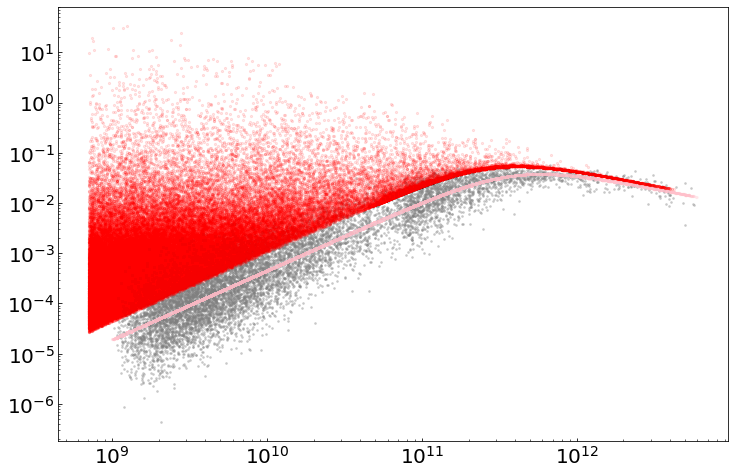

In [26]:
fig, ax = plt.subplots(1,1,figsize=(12,8),sharey=True,sharex=True)
# plt.subplots_adjust(wspace=0,hspace=0.1)

ax.set(xscale='log',yscale='log')      
ax.scatter(x=maxbig[randmask],y=maxstars[randmask]/maxbig[randmask],label="AM",color="grey",alpha=0.3,s=3)
ax.scatter(x=maxes,y=medes/maxes,label="AM",color="pink",alpha=0.1,s=5)
ax.scatter(x=mases,y=medes/mases,label="AM",color="red",alpha=0.1,s=5)
# fig.suptitle("Massive pairs",y=0.95)
# fig.supxlabel(r"$M_*/M_H$",y=0.06)
# fig.supylabel("Stellar mass (Msun)",x=0.060)

# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

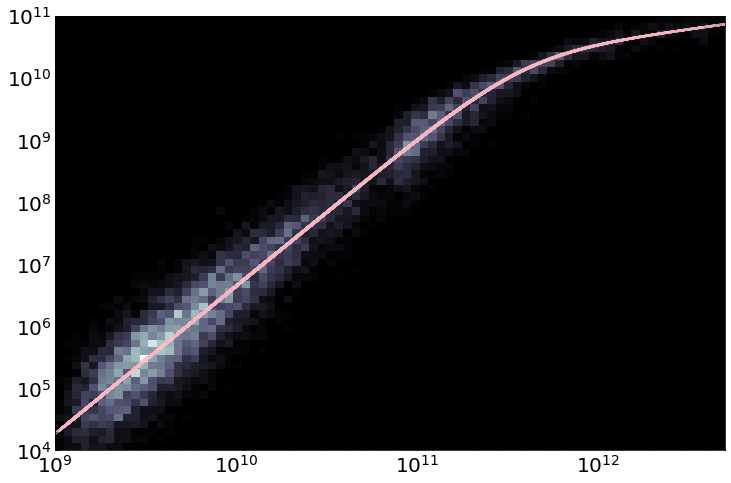

In [18]:
fig, ax = plt.subplots(1,1,figsize=(12,8),sharey=True,sharex=True)
# plt.subplots_adjust(wspace=0,hspace=0.1)

ax.set(xscale='log',yscale='log')      
ax.hist2d(x=maxbig[randmask],y=maxstars[randmask],bins=(np.logspace(9,12.7,80),np.logspace(4,11,60)),label="AM",cmap='bone')
ax.scatter(x=maxes,y=medes,label="AM",color="pink",alpha=0.1,s=5)
# fig.suptitle("Massive pairs",y=0.95)
# fig.supxlabel(r"$M_*/M_H$",y=0.06)
# fig.supylabel("Stellar mass (Msun)",x=0.060)

# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

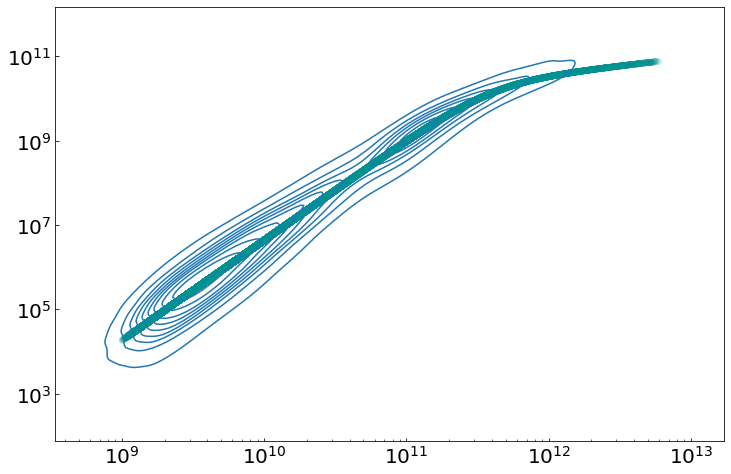

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,8),sharey=True,sharex=True)
# plt.subplots_adjust(wspace=0,hspace=0.1)

ax.set(xscale='log',yscale='log')      

sns.kdeplot(x=maxbig[randmask],y=maxstars[randmask],label="AM")

    
ax.scatter(x=maxes,y=medes,label="AM",color=palette['Illustris dark'],alpha=0.05)
# fig.suptitle("Massive pairs",y=0.95)
# fig.supxlabel(r"$M_*/M_H$",y=0.06)
# fig.supylabel("Stellar mass (Msun)",x=0.060)

# plt.savefig(f"../plots/separations/sepdist_{medianlabel}_{grouplabel}_{sizelabel}.png",bbox_inches='tight',facecolor="white")
plt.show()

In [31]:
import time

In [34]:
time.time()

1670368530.4135814

In [42]:
startt = time.time()
sim = "TNG"
groupCut=True
median=False
errorprint=False
redshiftcutoff=True
snap = 99
phys = 'hydro'
sepmask = "default"

if sim == "Illustris":
    snapshots = np.arange(0,136,1)
    snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
    redcutoff = 3.8
elif sim == "TNG":
    snapshots = np.arange(0,100,1)
    snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
    redcutoff = 4

redshifts = []  
med_pairs, med_major, med_minor = [], [], []
quart_pairs, quart_major, quart_minor = [], [], []

pair_path = f"{sim}_{snap}_100.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")

redshift = pair_data['Header'].attrs['Redshift']

# grabbing the relevant values
pairs = pair_data["pairs"][phys]

pri_stell = np.array(pairs["Sub1 Stellar Mass"])
sec_stell = np.array(pairs["Sub2 Stellar Mass"])
grouprads = np.array(pairs["Group Radius"])
seps = np.array(pairs["Separation"]) 

# masks            
paired_prims = get_primmask(pri_stell, size)
paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
paired_median = np.array( pairs['Realization'] )==-1
paired_sepcut = get_sepmask(seps, key=sepmask, **{"groupRadius":grouprads})

majors = (sec_stell/pri_stell > 1/4)
minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

paired_mask = paired_prims & paired_sepcut

if groupCut:
    paired_mask = paired_mask & paired_group

if median:
    paired_mask = paired_mask & paired_median

    major_mask = paired_mask & majors
    minor_mask = paired_mask & minors

    med_pairs_snap = np.median(seps[paired_mask])
    med_major_snap = np.median(seps[major_mask])
    med_minor_snap = np.median(seps[minor_mask])
    quart_pairs_snap = [0,0]
    quart_major_snap = [0,0]
    quart_minor_snap = [0,0]

elif ~median: 
    paired_per_real = []
    major_per_real = []
    minor_per_real = []

    realizations = np.unique( np.array(pairs['Realization']) )

    for real in realizations:
        print(real)
        paired_real = np.array( pairs['Realization'] ) == real

        paired_mask_real = paired_mask & paired_real
        major_mask_real = paired_mask_real & majors
        minor_mask_real = paired_mask_real & minors

        if np.count_nonzero(paired_mask_real) == 0:
            pair_xx = 0
            major_xx = 0
            minor_xx = 0

        else: 
            pair_xx = np.median(seps[paired_mask_real])

            if np.count_nonzero(major_mask_real) == 0:
                major_xx = 0
            else:
                major_xx = np.median(seps[major_mask_real])

            if np.count_nonzero(minor_mask_real) == 0:
                minor_xx = 0
            else:
                minor_xx = np.median(seps[minor_mask_real])

        paired_per_real.append( pair_xx )
        major_per_real.append( major_xx )
        minor_per_real.append( minor_xx )

    med_pairs_snap = np.median(paired_per_real)
    med_major_snap = np.median(major_per_real)
    med_minor_snap = np.median(minor_per_real)
    quart_pairs_snap = np.percentile( paired_per_real,[16,84] ) 
    quart_major_snap = np.percentile( major_per_real,[16,84] ) 
    quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 

redshifts.append( redshift )
med_pairs.append( med_pairs_snap )
med_major.append( med_major_snap )
med_minor.append( med_minor_snap )


quart_pairs.append( quart_pairs_snap )
quart_major.append( quart_major_snap )
quart_minor.append( quart_minor_snap )

endt = time.time()

dif = endt-startt
print(dif)

-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
0.8533010482788086


In [15]:
seps = get_seps("Illustris", "dark", "dwarf", sepmask="default")
    
# med = get_seps("Illustris", "dark", "dwarf", sepmask="default", median=True)

In [16]:
seps

{'z': array([3.70877426e+00, 3.49086137e+00, 3.28303306e+00, 3.08482264e+00,
        3.00813107e+00, 2.89578501e+00, 2.73314262e+00, 2.57729027e+00,
        2.44422570e+00, 2.31611074e+00, 2.20792547e+00, 2.10326965e+00,
        2.00202814e+00, 1.90408954e+00, 1.82268925e+00, 1.74357057e+00,
        1.66666956e+00, 1.60423452e+00, 1.53123903e+00, 1.47197485e+00,
        1.41409822e+00, 1.35757667e+00, 1.30237846e+00, 1.24847261e+00,
        1.20625808e+00, 1.15460271e+00, 1.11415056e+00, 1.07445789e+00,
        1.03551045e+00, 9.97294226e-01, 9.87852811e-01, 9.50531352e-01,
        9.23000816e-01, 8.86896938e-01, 8.51470901e-01, 8.16709979e-01,
        7.91068249e-01, 7.57441373e-01, 7.32636182e-01, 7.00106354e-01,
        6.76110411e-01, 6.44641841e-01, 6.21428745e-01, 5.98543288e-01,
        5.75980845e-01, 5.46392183e-01, 5.24565820e-01, 5.03047523e-01,
        4.81832943e-01, 4.60917794e-01, 4.40297849e-01, 4.19968942e-01,
        3.99926965e-01, 3.80167867e-01, 3.60687657e-01, 3.4

In [17]:
seps['medians']-med['medians']

KeyError: 'medians'

In [ ]:
pair_path = f"Illustris_135_10.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")



# grabbing the relevant values
pairs = pair_data["pairs"][phys]

pri_stell = np.array(pairs["Sub1 Stellar Mass"])
sec_stell = np.array(pairs["Sub2 Stellar Mass"])
seps = np.array(pairs["Separation"]) 

In [ ]:
# masks            
paired_prims = get_primmask(pri_stell, "dwarf")
paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
paired_median = np.array( pairs['Realization'] )==-1
paired_sepcut = get_sepmask(seps)

majors = (sec_stell/pri_stell > 1/4)
minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

paired_mask = paired_prims & paired_sepcut

paired_mask = paired_mask & paired_group


In [ ]:
pairs = pair_data["pairs"][phys]

pri_stell = np.array(pairs["Sub1 Stellar Mass"])
sec_stell = np.array(pairs["Sub2 Stellar Mass"])
seps = np.array(pairs["Separation"]) 

# masks            
paired_prims = get_primmask(pri_stell, size)
paired_group = get_groupmask(np.array(pairs["Group Mass"]), size)
paired_median = np.array( pairs['Realization'] )==-1
paired_sepcut = get_sepmask(seps)

majors = (sec_stell/pri_stell > 1/4)
minors = (sec_stell/pri_stell > 1/10) & (sec_stell/pri_stell < 1/4)

paired_mask = paired_prims & paired_sepcut

In [ ]:
paired_mask = paired_mask & paired_group

paired_per_real = []
major_per_real = []
minor_per_real = []

realizations = np.unique( np.array(pairs['Realization']) )

In [ ]:
for real in realizations:
    paired_real = np.array( pairs['Realization'] ) == real

    paired_mask = paired_mask & paired_real
    major_mask = paired_mask & majors
    minor_mask = paired_mask & minors

    paired_per_real.append( np.median(seps[paired_mask]) )
    major_per_real.append( np.median(seps[major_mask]) )
    minor_per_real.append( np.median(seps[minor_mask]) )

med_pairs_snap = np.median(paired_per_real)
med_major_snap = np.median(major_per_real)
med_minor_snap = np.median(minor_per_real)
quart_pairs_snap = np.percentile( paired_per_real,[16,84] ) 
quart_major_snap = np.percentile( major_per_real,[16,84] ) 
quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 

In [ ]:
paired_per_real

In [ ]:
redshifts.append( redshift )
med_pairs.append( med_pairs_snap )
med_major.append( med_major_snap )
med_minor.append( med_minor_snap )


quart_pairs.append( quart_pairs_snap )
quart_major.append( quart_major_snap )
quart_minor.append( quart_minor_snap )

In [ ]:
ill1 = get_seps("Illustris", "dark", "dwarf", groupCut=False)
ill2 = get_seps("Illustris", "dark", "dwarf", groupCut=True)
ill3 = get_seps("Illustris", "dark", "dwarf", **{"groupCut":True})

print(ill1['All Median']-ill2['All Median'])
print(ill1['All Median']-ill3['All Median'])
print(ill2['All Median']-ill3['All Median'])

In [ ]:
ill1

In [ ]:
kwarg_dict = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":False,
              "sepmask":"default"}

illd = get_seps("TNG", "dark", "dwarf", **kwarg_dict)
illh = get_seps("TNG", "hydro", "dwarf", **kwarg_dict)